<a href="https://colab.research.google.com/github/ANTRIKSH-GANJOO/pytorch_research/blob/main/WithReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 98454991.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


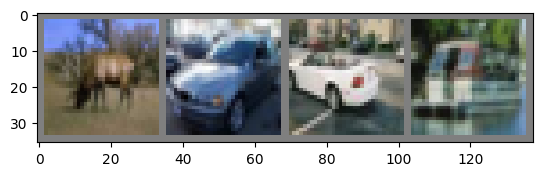

deer  car   car   ship 


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.conv1(x)
        flat_out = [p.flatten() for p in out]
        # Calculate the sum of L1 norms
        sum_l1_norm = sum(torch.linalg.norm(p, 1) for p in flat_out)
        # Calculate the sum of squared L2 norms
        sum_squared_l2_norm = sum(p.pow(2).sum() for p in flat_out)
        # Calculate the quotient
        quotient = sum_l1_norm / sum_squared_l2_norm
        # Calculate the final result
        result = 2 ** quotient
        reg = result
        out = self.layer1(out)
        flat_out = [p.flatten() for p in out]
        sum_l1_norm = sum(torch.linalg.norm(p, 1) for p in flat_out)
        # Calculate the sum of squared L2 norms
        sum_squared_l2_norm = sum(p.pow(2).sum() for p in flat_out)
        # Calculate the quotient
        quotient = sum_l1_norm / sum_squared_l2_norm
        # Calculate the final result
        result = 2 ** quotient
        reg = reg + result
        out = self.layer2(out)
        flat_out = [p.flatten() for p in out]
        sum_l1_norm = sum(torch.linalg.norm(p, 1) for p in flat_out)
        # Calculate the sum of squared L2 norms
        sum_squared_l2_norm = sum(p.pow(2).sum() for p in flat_out)
        # Calculate the quotient
        quotient = sum_l1_norm / sum_squared_l2_norm
        # Calculate the final result
        result = 2 ** quotient
        reg = reg + result
        out = self.layer3(out)
        flat_out = [p.flatten() for p in out]
        flat_out = [p.flatten() for p in out]
        sum_l1_norm = sum(torch.linalg.norm(p, 1) for p in flat_out)
        # Calculate the sum of squared L2 norms
        sum_squared_l2_norm = sum(p.pow(2).sum() for p in flat_out)
        # Calculate the quotient
        quotient = sum_l1_norm / sum_squared_l2_norm
        # Calculate the final result
        result = 2 ** quotient
        reg = reg + result
        out = self.layer4(out)
        flat_out = [p.flatten() for p in out]
        sum_l1_norm = sum(torch.linalg.norm(p, 1) for p in flat_out)
        # Calculate the sum of squared L2 norms
        sum_squared_l2_norm = sum(p.pow(2).sum() for p in flat_out)
        # Calculate the quotient
        quotient = sum_l1_norm / sum_squared_l2_norm
        # Calculate the final result
        result = 2 ** quotient
        reg = reg + result
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out,reg


def ResNet18():

    return ResNet(ResidualBlock)

my_net = ResNet18()

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9)

In [16]:
# Training the Neural Network

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs,reg = my_net(inputs)
        loss = criterion(outputs, labels)
        c = loss + reg
        c.backward()
        optimizer.step()

        # print statistics
        running_loss += c.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 9.737
[1,  4000] loss: 9.730
[1,  6000] loss: 9.728
[1,  8000] loss: 9.731
[1, 10000] loss: 9.724
[1, 12000] loss: 9.732
Finished Training
